In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from tqdm import tqdm
import itertools

# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)

In [2]:
ratings = pd.read_csv('goodbooks-10k/ratings.csv')
books = pd.read_csv('goodbooks-10k/books.csv')
tags = pd.read_csv('goodbooks-10k/tags.csv')
book_tags = pd.read_csv('goodbooks-10k/book_tags.csv')

In [3]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [5]:
ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


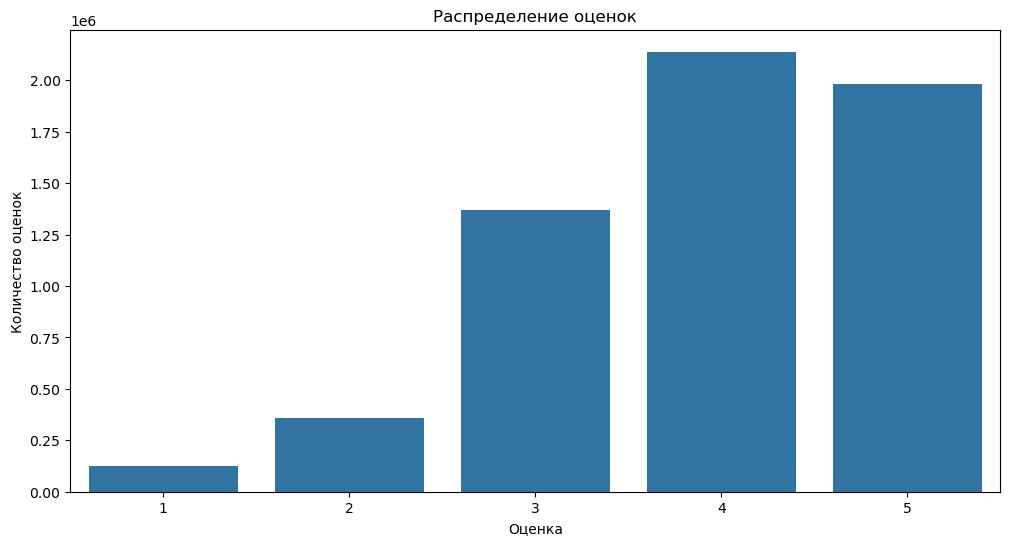

In [6]:
plt.figure(figsize=(12,6))
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.countplot(x='rating', data=ratings, order=sorted(ratings['rating'].unique()))
plt.title('Распределение оценок')
plt.show()

### Большинство пользователей склоны выставлять хорошие оценки, нежели плохие

In [7]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

### Заполним пропуски по столбцу original_title столбцом tittle

In [9]:
books['original_title'] = books['original_title'].fillna(books['title'])

In [10]:
books.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


### Нас интересуют колонки book_id, goodreads_book_id, authors и title. С ними, на первый взгляд, всё ок

In [11]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [12]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [13]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [14]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [15]:
tags['tag_name'].unique()

array(['-', '--1-', '--10-', ..., 'Ｍａｎｇａ', 'ＳＥＲＩＥＳ', 'ｆａｖｏｕｒｉｔｅｓ'],
      dtype=object)

### Проверим корректность ключей для соединения файлов

In [16]:
# Проверим, совпадают ли ID между books и ratings, book_tags и books, book_tags и tags
print('Совпадающих ID (book_id):', len(set(ratings['book_id']) & set(books['book_id'])))
print('Совпадающих goodreads_book_id:', len(set(book_tags['goodreads_book_id']) & set(books['goodreads_book_id'])))
print('Совпадающих tag_id:', len(set(book_tags['tag_id']) & set(tags['tag_id'])))

Совпадающих ID (book_id): 10000
Совпадающих goodreads_book_id: 10000
Совпадающих tag_id: 34252


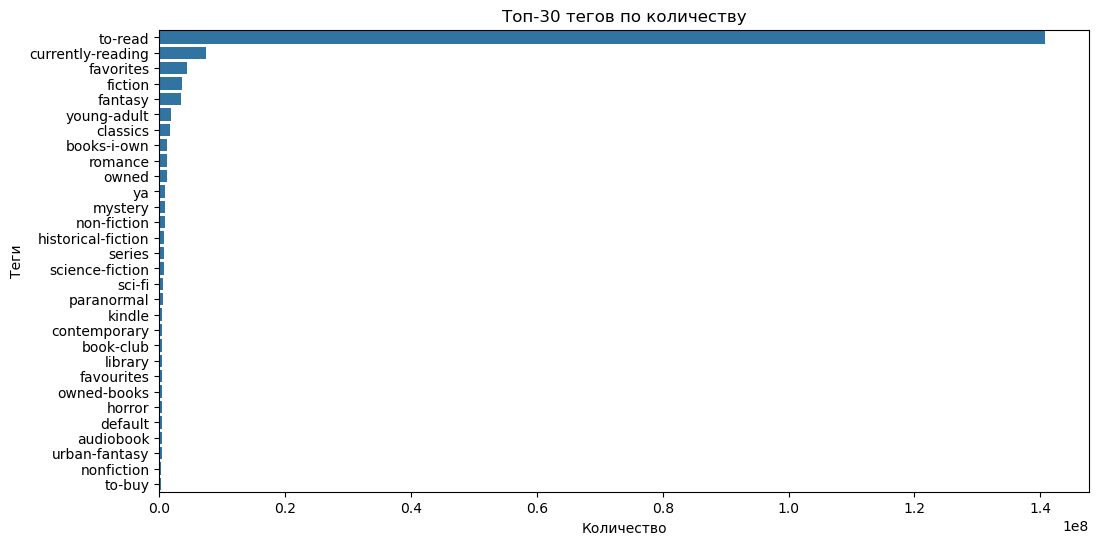

In [17]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12,6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

### Некоторые популярные теги не несут смысловой нагрузки (to-read, to-buy). Также наблюдали мусорные теги. Если не вычистить такие теги, то контентная модель (TF-IDF по тегам) не будет давать осмысленной близости

### Выкинем теги, не несущие смысловой нагрузки

In [18]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains('owned|favorites|currently-reading|series|books-i-own|to-|default|ebook|audiobook|audio|library|book-club|favourites')]
tags

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,ｃhildrens
34248,34248,ｆａｖｏｒｉｔｅｓ
34249,34249,ｍａｎｇａ
34250,34250,ｓｅｒｉｅｓ


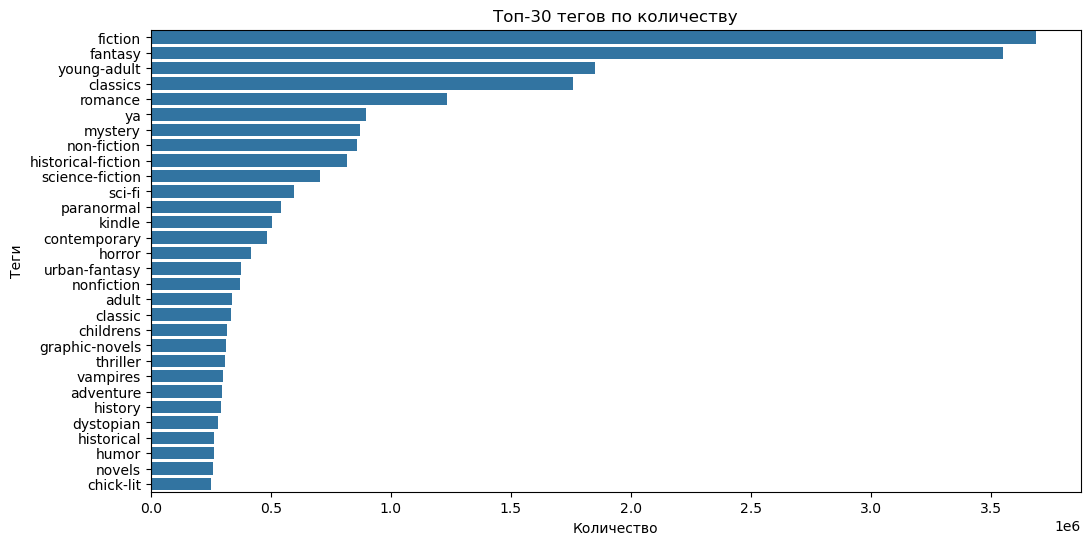

In [19]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12, 6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

### Также удалим теги, которые содержат цифры и другие спец.символы, и возьмем 10000 популярных тегов

In [20]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=]')]
tags = tags[tags['tag_name'].str.match(r'^[a-zA-Z\s\-]+$')]
tags = tags[~tags['tag_name'].str.match(r'^[-]')]
tags = tags[~tags['tag_name'].str.match(r'[-]$')]
tags = tags[tags['tag_name'].isin(book_tags.merge(tags, on='tag_id', how='inner').groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)['tag_name'].head(10000))]
tags

,tag_id,tag_name
1291,1291,a
1294,1294,a-a-milne
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie
...,...,...
33265,33265,zombie-fiction
33268,33268,zombies
33272,33272,zoo
33275,33275,zoology


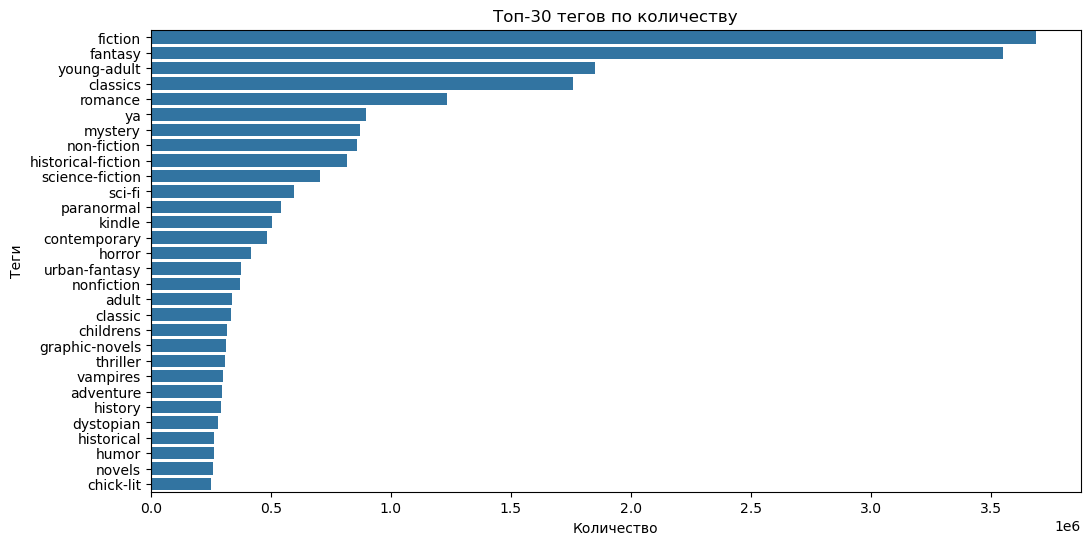

In [21]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12, 6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

### Мусорные теги остались, но их количество невелико (не входят в топ-30). Попробуем поработать с ними. Если будет плохо, вернемся к итерации отчистки

# Этап 2: базовые и контентные модели

### Неперсонализированная модель

In [22]:
book_stats = ratings.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
def get_top_n_popularityular(N=10, min_count=20):
    top = book_stats[book_stats['n_ratings'] >= min_count].sort_values('mean_rating', ascending=False).head(N)
    print('Топ популярных книг')
    return top.merge(books[['book_id','original_title']], on='book_id', how='left')

get_top_n_popularityular(5)

Топ популярных книг


,book_id,mean_rating,n_ratings,original_title
0,3628,4.829876,482,The Complete Calvin and Hobbes
1,7947,4.818182,88,ESV Study Bible
2,9566,4.768707,147,Attack of the Deranged Mutant Killer Monster Snow Goons: A Calvin and Hobbes Collection
3,6920,4.766355,214,The Indispensable Calvin and Hobbes: A Calvin and Hobbes Treasury
4,8978,4.761364,176,The Revenge of the Baby-Sat: A Calvin and Hobbes Collection


### Контентная модель

In [23]:
#Объединяем книги и теги
book_with_tags = book_tags.merge(books[['book_id','goodreads_book_id']], on='goodreads_book_id', how='inner').merge(tags[['tag_id','tag_name']], on='tag_id', how='inner')
book_tags_grouped = book_with_tags.groupby('book_id')['tag_name'].apply(lambda tags: ' '.join(sorted(set(tags)))).reset_index().rename(columns={'tag_name':'tag_profile'})
book_profiles = books[['book_id','original_title']].merge(book_tags_grouped, on='book_id', how='left')
book_profiles['tag_profile'] = book_profiles['tag_profile'].fillna('')
book_profiles['text_profile'] = (book_profiles['original_title'].fillna('') + ' ' + book_profiles['tag_profile']).str.lower()

# TF-IDF
tfidf_matrix = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1,2)).fit_transform(book_profiles['text_profile'])

# Нужны для быстрого обращения к строкам TF-IDF
bookid_to_index = {bid: idx for idx, bid in enumerate(book_profiles['book_id'])}
index_to_bookid = {idx: bid for bid, idx in bookid_to_index.items()}

def get_similar_books(book_id, N=5, turn_on_info=True):
    if book_id not in bookid_to_index:
        return []
    idx = bookid_to_index[book_id]
    sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).ravel()
    best = sims.argsort()[::-1]
    results = []
    for i in best:
        bid = int(book_profiles.loc[i,'book_id'])
        if bid == book_id:
            continue
        results.append({'book_id':bid, 'title': book_profiles.loc[i,'original_title'], 'score': float(sims[i])})
        if len(results) >= N:
            break
    if turn_on_info:
        print(f'Похожие книги на {book_profiles.loc[book_id,'original_title']}:')
        return results
    else:
        results_with_no_info = []
        print(f'Похожие книги на {book_profiles.loc[book_id,'original_title']}:')
        for i in range(len(results)):
            results_with_no_info.append(results[i]['title'])
        return results_with_no_info

# Пример
get_similar_books(book_profiles['book_id'].iloc[8], N=5)

Похожие книги на Pride and Prejudice:


[{'book_id': 26, 'title': 'The Da Vinci Code', 'score': 0.7650811421352915},
 {'book_id': 170, 'title': 'Digital Fortress', 'score': 0.7399699566821571},
 {'book_id': 201, 'title': 'The Lost Symbol', 'score': 0.7201933969755475},
 {'book_id': 145, 'title': 'Deception Point', 'score': 0.6831798117828112},
 {'book_id': 240, 'title': 'Inferno', 'score': 0.6717702206135213}]

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)

In [24]:
# Создаём разреженную матрицу пользователь–книга
def build_sparse_matrix(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    u2i = {u:i for i,u in enumerate(users)}
    b2i = {b:i for i,b in enumerate(books)}
    rows = df['user_id'].map(u2i)
    cols = df['book_id'].map(b2i)
    data = df['rating'].astype(float)
    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(books)))
    return R, u2i, b2i, users, books

# Делает предсказание рейтинга пользователя для конкретной книги на основе похожих книг, которые он уже оценил
def predict_item_based(R, u2i, b2i, user_id, target_book_id, K=20):
    if user_id not in u2i or target_book_id not in b2i:
        return ratings['rating'].mean()
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    uidx = u2i[user_id]
    tidx = b2i[target_book_id]
    sims = item_user_norm.dot(item_user_norm[tidx].T).toarray().ravel()
    user_rated = R[uidx].nonzero()[1]
    if len(user_rated) == 0:
        return ratings['rating'].mean()
    rated_sims = [(i, sims[i]) for i in user_rated]
    rated_sims = sorted(rated_sims, key=lambda x: x[1], reverse=True)[:K]
    num = 0.0; den = 0.0
    for i,s in rated_sims:
        r = R[uidx, i]
        num += s * r
        den += abs(s)
    return float(num/den) if den != 0 else ratings['rating'].mean()

# Делает топ-N рекомендаций книг пользователю
def itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id, N=10, K=20):
    if user_id not in u2i:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    uidx = u2i[user_id]
    user_rated_indices = R[uidx].nonzero()[1]
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    agg = np.zeros(len(books_arr))
    if len(user_rated_indices) == 0:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# Пример
R, u2i, b2i, users_arr, books_arr = build_sparse_matrix(ratings)
print(f'Ожидаемый рейтинг пользователя 123 для книги 50: {predict_item_based(R, u2i, b2i, user_id=123, target_book_id=50)}')
print('Рекомендованные книги:', itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id=123, N=5))

Ожидаемый рейтинг пользователя 123 для книги 50: 4.2769726194968625
Рекомендованные книги: [31, 1, 33, 2, 17]


# Этап 4: матричные разложения (Matrix Factorization)

In [25]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(ratings[['user_id','book_id','rating']], reader)
trainset_s, testset_s = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)
algo = SVD(n_factors=120, n_epochs=25, lr_all=0.005, reg_all=0.02, random_state=42).fit(trainset_s)
preds = algo.test(testset_s)
print('RMSE:', accuracy.rmse(preds))

def get_recommendations(user_id, N=5):
    books_for_rec = [b for b in ratings['book_id'].unique() if b not in set(ratings[ratings['user_id'] == user_id]['book_id'])]
    if not books_for_rec:
        return []
    preds = sorted([algo.predict(uid=user_id, iid=b) for b in books_for_rec], key=lambda x: x.est, reverse=True)[:N]
    recs = []
    for p in preds:
        title = books.loc[books['book_id'] == p.iid, 'original_title'].values
        title = title[0] if len(title) > 0 else "Нет названия"
        recs.append({'book_id': int(p.iid), 'title': title, 'pred_rating': round(p.est, 3)})
    return recs

# Пример
user_id = 123
recommendations = get_recommendations(user_id, N=5)

print(f"Рекомендации для пользователя {user_id}:")
for r in recommendations:
    print(f"- {r['title']} (book_id={r['book_id']}, предсказанный рейтинг={r['pred_rating']})")

RMSE: 0.8324
RMSE: 0.8324060729191541
Рекомендации для пользователя 123:
- The True Confessions of Charlotte Doyle (book_id=1639, предсказанный рейтинг=5)
- دیوان‎‎ [Dīvān] (book_id=8946, предсказанный рейтинг=5)
- ノルウェイの森 [Noruwei no Mori] (book_id=380, предсказанный рейтинг=5)
- Redeeming Love (book_id=504, предсказанный рейтинг=5)
- Pope Joan (book_id=1757, предсказанный рейтинг=5)


# Этап 5: оценка и сравнение моделей

In [26]:
# Делаем разбиение по пользователям
def train_test_split(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list=[]; test_list=[]
    for uid, g in df.groupby('user_id'):
        n = len(g)
        if n < 2:
            train_list.append(g)
            continue
        test_n = max(1, int(n * test_size))
        test_idx = np.random.choice(g.index, size=test_n, replace=False)
        test_list.append(g.loc[test_idx])
        train_list.append(g.drop(test_idx))
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split(ratings, test_size=0.2, seed=42)
print('Размеры train/test')
print(f'train - {len(train_df)}, test - {len(test_df)}')

user_relevant = test_df[test_df['rating'] >= 4].groupby('user_id')['book_id'].apply(set).to_dict()

# Popularity
book_stats_train = train_df.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
popular_books_train = book_stats_train[book_stats_train['n_ratings']>=20].sort_values('mean_rating', ascending=False)
def popularity_recommender(user_id, N=10):
    return popular_books_train.head(N)['book_id'].astype(int).tolist()

# Content-based
def content_recommender(user_id, N=10):
    seen = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if not seen:
        return popularity_recommender(user_id, N)
    sims = np.zeros(tfidf_matrix.shape[0], dtype=float)
    seen_idxs = [bookid_to_index[b] for b in seen if b in bookid_to_index]
    if not seen_idxs:
        return popularity_recommender(user_id, N)
    for si in seen_idxs:
        sims += cosine_similarity(tfidf_matrix[si], tfidf_matrix).ravel()
    sims /= max(1, len(seen_idxs))
    ranked = np.argsort(sims)[::-1]
    recs = []
    for idx in ranked:
        bid = int(book_profiles.loc[idx, 'book_id'])
        if bid in seen:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# ItemCF
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=20):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)

    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)

    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)

    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))

    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# SVD
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

algo = SVD(
    n_factors=300, 
    n_epochs=50, 
    lr_all=0.004, 
    reg_all=0.01, 
    random_state=42
)
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df['book_id'].unique()
    seen_train = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if (user_id not in set(train_df['user_id'])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)

    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=b).est
        except Exception:
            est = train_df['rating'].mean()
        preds.append((int(b), float(est)))
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]

# Расчет метрик
def precision_at_k(rec, rel, k=10):
    if not rec: return 0.0
    return len(set(rec[:k]) & set(rel)) / k

def recall_at_k(rec, rel, k=10):
    if not rel: return 0.0
    return len(set(rec[:k]) & set(rel)) / len(rel)

def ndcg_at_k(rec, rel, k=10):
    dcg = 0.0
    for i, r in enumerate(rec[:k]):
        if r in rel:
            dcg += 1.0 / np.log2(i+2)
    ideal = sum(1.0 / np.log2(i+2) for i in range(min(len(rel), k)))
    return dcg/ideal if ideal>0 else 0.0

# Модели
models = {
    'Popularity': popularity_recommender,
    'Content': content_recommender,
    'ItemCF': itemcf_recommender,
    'SVD': svd_recommender
}

# Результат
results = []
for name, rec_fn in models.items():
    precs = []
    recs_ = []
    ndcgs = []

    print(f"Идёт обучение следующей модели: {name}")
    for uid in tqdm(list(user_relevant.keys())[:1000], desc=f"{name}", leave=False):
        rel = user_relevant.get(uid, set())
        if not rel:
            continue
        recs_list = rec_fn(uid, N=10)
        precs.append(precision_at_k(recs_list, rel, 10))
        recs_.append(recall_at_k(recs_list, rel, 10))
        ndcgs.append(ndcg_at_k(recs_list, rel, 10))

    results.append({
        'model': name,
        'precision@10': np.mean(precs) if precs else 0.0,
        'recall@10': np.mean(recs_) if recs_ else 0.0,
        'nDCG@10': np.mean(ndcgs) if ndcgs else 0.0,
        'n_users': len(precs)
    })

metrics_df = pd.DataFrame(results).set_index('model')
metrics_df

Размеры train/test
train - 4802569, test - 1173910
Идёт обучение следующей модели: Popularity


Идёт обучение следующей модели: Content


Идёт обучение следующей модели: ItemCF


Идёт обучение следующей модели: SVD


,precision@10,recall@10,nDCG@10,n_users
model,,,,
Popularity,0.0015,0.001253,0.001361,1000
Content,0.0834,0.059503,0.096540,1000
ItemCF,0.1577,0.112402,0.188068,1000
SVD,0.0174,0.011480,0.020811,1000


### Popularity

Метрики практически нулевые, но это ожидаемо, так как модель не использует индивидуальные предпочтения, только самые популярные книги по среднему рейтингу и количеству оценок

### Content-based filtering

Метрики говорят о том, что контент книги действительно отражает вкусы пользователя

Однако модель ограничена тем, что учитывает только признаки самих книг, без данных о других пользователях, поэтому метрики не слишком высокие

### ItemCF (Item-based Collaborative Filtering)

Использует поведение всех пользователей: если два произведения часто читаются одними и теми же людьми, они считаются похожими

Лучшие метрики среди всех моделей, потому что хорошо улавливает «коллективные закономерности» в поведении читателей

### SVD (матричное разложение)

Учитывает как поведение пользователей, так и скрытые факторы взаимодействий

Метрики выше, чем у базовой популярности, но ниже, чем у Content и ItemCF

Это говорит о том, что SVD пока не полностью раскрывает структуру предпочтений пользователей в текущих данных

# Этап 6: гибридизация и выводы

### Идея гибридного подхода ###

Чтобы улучшить качество рекомендаций и решить проблему холодного старта, можно объединить несколько моделей (использовать гибридную систему, которая выбирает подходящий метод в зависимости от ситуации):

Если у книги оценок нет, то использовать контентные рекомендации, так как они опираются не на рейтинги, а на описание книги (TF-IDF, жанры, аннотации и т.д.)

Если книга уже имеет достаточно оценок, то использовать SVD, так как он хорошо улавливает скрытые зависимости между пользователями и книгами, когда данных достаточно

Если пользователь новый, то можно показывать популярные книги

### Общие выводы по работе ###

В текущем эксперименте ItemCF показал наилучшее качество, потому что он наиболее эффективно использует взаимодействия пользователей и книг

In [27]:
pd.DataFrame({'Модель': ['Popularity', 'Content-based', 'ItemCF', 'SVD'],
              '+': ['Простая и быстрая', 'Работает для новых книг, можно использовать тексты и описания', 'Учитывает вкусы пользователей', 'Улавливает скрытые зависимости между пользователями и книгами'],
              '-': ['Не персонализирована, все пользователи видят одно и то же', 'Не учитывает интересы конкретного пользователя, только схожесть между книгами', 'Проблема холодного старта', 'Проблема холодного старта']
              })

,Модель,+,-
0,Popularity,Простая и быстрая,"Не персонализирована, все пользователи видят одно и то же"
1,Content-based,"Работает для новых книг, можно использовать тексты и описания","Не учитывает интересы конкретного пользователя, только схожесть между книгами"
2,ItemCF,Учитывает вкусы пользователей,Проблема холодного старта
3,SVD,Улавливает скрытые зависимости между пользователями и книгами,Проблема холодного старта


### Идеи для улучшения ###

1. Использовать гибритизацию

2. Вместо TF-IDF применить Word2Vec, BERT или Sentence-BERT, чтобы учитывать само описание книг, а не только совпадение слов

3. Добавление признаков пользователей

4. Использовать нейросетевые модели

# Итоговый проект: разработка гибридной системы рекомендаций книг с нейросетевыми моделями #

## Базовая часть ##

### Этап 1. Улучшенная подготовка данных ###

#### Признаки пользователей ####

In [28]:
# Рассчитываем статистические характеристики для каждого пользователя
user_features = train_df.groupby('user_id')['rating'].agg(user_mean_rating='mean', user_rating_count='count', user_rating_std='std').fillna(0)

# Нормализация
user_features[['user_mean_rating', 'user_rating_count', 'user_rating_std']] = MinMaxScaler().fit_transform(user_features[['user_mean_rating', 'user_rating_count', 'user_rating_std']])

user_features.head(5)

,user_mean_rating,user_rating_count,user_rating_std
user_id,,,
1,0.630319,0.541667,0.482079
2,0.841346,0.250000,0.429435
3,0.191781,0.395833,0.410275
4,0.687500,0.638889,0.504613
5,0.775000,0.444444,0.350180


#### Признаки книг ####

In [29]:
# Для каждой книги вычисляем стат.данные
book_features = train_df.groupby('book_id')['rating'].agg(book_mean_rating='mean', book_rating_count='count', book_rating_std='std').fillna(0)

book_features[['book_mean_rating', 'book_rating_count', 'book_rating_std']] = MinMaxScaler().fit_transform(book_features[['book_mean_rating', 'book_rating_count', 'book_rating_std']])

book_features.head(5)

,book_mean_rating,book_rating_count,book_rating_std
book_id,,,
1,0.790641,1.000000,0.367305
2,0.816752,0.950682,0.361749
3,0.404010,0.735050,0.837459
4,0.808967,0.831894,0.359516
5,0.604830,0.723643,0.533132


#### Признаки взаимодействий ####

In [30]:
# Построение профилей пользователей на основе TF-IDF
user_profiles = {}
for uid, books in tqdm(train_df.groupby('user_id')['book_id'], desc="Построение признака пользователя"):
    idxs = [bookid_to_index[b] for b in books if b in bookid_to_index]
    if not idxs:
        continue
    profile_vec = tfidf_matrix[idxs].mean(axis=0)
    profile_vec = normalize(np.asarray(profile_vec))
    user_profiles[uid] = profile_vec


# Функция расчёта схожести книги с профилем пользователя
def user_book_sim(user_id, book_id):
    if user_id not in user_profiles or book_id not in bookid_to_index:
        return 0
    user_vec = user_profiles[user_id]
    book_vec = tfidf_matrix[bookid_to_index[book_id]].toarray().ravel()
    return float(np.dot(user_vec, book_vec))


# Формирование interaction-признаков
interaction_features = []
for row in tqdm(train_df.itertuples(index=False), total=len(train_df), desc="Формирование interaction-признаков"):
    sim = user_book_sim(row.user_id, row.book_id)
    deviation = row.rating - user_features.loc[row.user_id, 'user_mean_rating']
    interaction_features.append((row.user_id, row.book_id, sim, deviation))

interaction_df = pd.DataFrame(interaction_features, columns=['user_id', 'book_id', 'similarity', 'rating_deviation'])
interaction_df.head(5)

Формирование interaction-признаков:   0%|          | 0/4802569 [00:00<?, ?it/s]C:\Users\Игнат\AppData\Local\Temp\ipykernel_23500\2942541949.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.dot(user_vec, book_vec))
Формирование interaction-признаков: 100%|██████████| 4802569/4802569 [11:33<00:00, 6927.92it/s]


,user_id,book_id,similarity,rating_deviation
0,1,268,0.406866,2.369681
1,1,5556,0.198827,2.369681
2,1,3638,0.505690,2.369681
3,1,867,0.486688,2.369681
4,1,47,0.434803,2.369681


### Этап 2. Построение гибридной системы ###

In [31]:
# Объединение всех признаков в единую таблицу
hybrid_features = (train_df.merge(user_features, on='user_id', how='left').merge(book_features, on='book_id', how='left').merge(interaction_df[['user_id', 'book_id', 'similarity', 'rating_deviation']], on=['user_id', 'book_id'], how='left'))
hybrid_features.head()

,user_id,book_id,rating,user_mean_rating,user_rating_count,user_rating_std,book_mean_rating,book_rating_count,book_rating_std,similarity,rating_deviation
0,1,268,3,0.630319,0.541667,0.482079,0.577012,0.166096,0.522692,0.406866,2.369681
1,1,5556,3,0.630319,0.541667,0.482079,0.446746,0.010917,0.532208,0.198827,2.369681
2,1,3638,3,0.630319,0.541667,0.482079,0.562878,0.018196,0.516583,0.505690,2.369681
3,1,867,3,0.630319,0.541667,0.482079,0.601050,0.060073,0.499969,0.486688,2.369681
4,1,47,3,0.630319,0.541667,0.482079,0.801940,0.456738,0.369890,0.434803,2.369681


In [32]:
# Делим пользователей на две группы
user_activity = train_df.groupby('user_id')['rating'].count()
new_users = user_activity[user_activity <= user_activity.quantile(0.2)].index
active_users = user_activity[user_activity > user_activity.quantile(0.2)].index
print(f"Новых пользователей: {len(new_users)}, активных: {len(active_users)}")

# Генерация кандидатов
def generate_candidate_books(user_id, N_candidates=50):
    candidates = set()
    
    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(popularity_recommender(user_id, N=N_candidates))
    else:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(itemcf_recommender(R_train, u2i, b2i, users_train, books_train, user_id, N=N_candidates))
        candidates.update(svd_recommender(user_id, N=N_candidates))
        candidates.update(popularity_recommender(user_id, N=N_candidates))
    
    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)

# Отобрем лучшие рекомендации
def hybrid_recommender(user_id, N=10):
    candidates = set()
    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=100))
        candidates.update(popularity_recommender(user_id, N=100))
    else:
        candidates.update(content_recommender(user_id, N=100))
        candidates.update(itemcf_recommender(R_train, u2i, b2i, users_train, books_train, user_id, N=100))
        candidates.update(svd_recommender(user_id, N=100))
        candidates.update(popularity_recommender(user_id, N=100))
    
    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)[:N]

Новых пользователей: 10910, активных: 42514


### Этап 3. Оценка и оптимизация гибридной системы ###

#### Кэшируем предсказания моделей для ускорения вычислений, чтобы модель не пересчитывалась каждый раз ####

In [35]:
cache = {'content': {}, 'itemcf': {}, 'svd': {}, 'popularity': {}}

#Посчитаем метрики пока что на 1000 пользователях, иначе очень долго будет считаться
test_users = test_df['user_id'].unique()[:1000]

print("Кэшируем предсказания моделей для всех тестовых пользователей")
for uid in tqdm(test_users, desc="Content-based"):
    cache['content'][uid] = content_recommender(uid, N=100)

for uid in tqdm(test_users, desc="ItemCF"):
    cache['itemcf'][uid] = itemcf_recommender(uid, N=100)

for uid in tqdm(test_users, desc="SVD"):
    cache['svd'][uid] = svd_recommender(uid, N=100)

for uid in tqdm(test_users, desc="Popularity"):
    cache['popularity'][uid] = popularity_recommender(uid, N=100)
print("Все предсказания закэшированы")

Кэшируем предсказания моделей для всех тестовых пользователей


Popularity: 100%|██████████| 1000/1000 [00:00<00:00, 10945.64it/s]

Все предсказания закэшированы


In [38]:
# Гибридная модель
def hybrid_model(user_id, w_content=0.3, w_itemcf=0.3, w_svd=0.3, w_popularity=0.1, N=10):
    if user_id in new_users:
        # Решаем проблему холодного старта
        models = {
            'content': cache['content'].get(user_id, []),
            'popularity': cache['popularity'].get(user_id, [])
        }
        weights = {'content': 0.7, 'popularity': 0.3}
    else:
        # Комбинация моделей
        models = {
            'content': cache['content'].get(user_id, []),
            'itemcf': cache['itemcf'].get(user_id, []),
            'svd': cache['svd'].get(user_id, []),
            'popularity': cache['popularity'].get(user_id, [])
        }
        weights = {'content': w_content, 'itemcf': w_itemcf, 'svd': w_svd, 'popularity': w_popularity}

    cands = {}
    for m, recs in models.items():
        for i, b in enumerate(recs):
            # Взвешенное усреднение с учетом позиции книги в списке
            cands[b] = cands.get(b, 0) + weights[m] * (1 / (i + 1))

    return [b for b, _ in sorted(cands.items(), key=lambda x: x[1], reverse=True)[:N]]

# Функция оценки модели на тесте
def eval_model(model_func, users, k=10):
    precisions, recalls, ndcgs = [], [], []
    for uid in users:
        preds = model_func(uid, N=k)
        true_books = user_relevant.get(uid, set())
        if not true_books:
            continue
        hits = len(set(preds) & true_books)
        precisions.append(hits / k)
        recalls.append(hits / len(true_books))
        dcg = 0
        for i, p in enumerate(preds[:k]):
            if p in true_books:
                dcg += 1.0 / np.log2(i + 2)  # i+2, так как позиции начинаются с 0
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_books), k)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    if not precisions:
        return 0, 0, 0
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

#### Поиск оптимального веса ####

In [42]:
weights_list = [(a, b, c, d) for a, b, c, d in itertools.product([0.1, 0.2, 0.3, 0.4], repeat=4) if abs(a + b + c + d - 1.0) < 1e-6]

best_score = 0
best_weights = None

for w in tqdm(weights_list, desc="Оптимизация весов"):
    w_content, w_itemcf, w_svd, w_popularity = w
    p, r, d = eval_model(lambda uid, N: hybrid_model(uid, w_content, w_itemcf, w_svd, w_popularity, N=N), test_users)
    score = (p + r) / 2
    if score > best_score:
        best_score = score
        best_weights = w

print(f"Лучшие веса: {best_weights}, средняя метрика={best_score}")


Оптимизация весов: 100%|██████████| 44/44 [00:06<00:00,  6.93it/s]

Лучшие веса: (0.4, 0.4, 0.1, 0.1), средняя метрика=0.10535624202322028


#### Оценка ####

In [43]:
best_w_content, best_w_itemcf, best_w_svd, best_w_popularity = best_weights

for seg_name, seg_users in [("Новые пользователи", [u for u in new_users if u in test_users]), ("Активные пользователи", [u for u in active_users if u in test_users])]:
    p_h, r_h, ndcg_h = eval_model(lambda uid, N: hybrid_model(uid, best_w_content, best_w_itemcf, best_w_svd, best_w_popularity, N=10), seg_users)
    print(f"{seg_name}: Precision@10={p_h}, Recall@10={r_h}, nDCG@10={ndcg_h}")

Новые пользователи: Precision@10=0.06666666666666667, Recall@10=0.062131472779620917, nDCG@10=0.08919116094062199
Активные пользователи: Precision@10=0.13488649940262845, Recall@10=0.09168037392126108, nDCG@10=0.15621552480538695


#### Выводы ####

Гибридная модель показывает высокие метрики на активных пользователях, на новых пользователях гибрид также даёт осмысленные рекомендации

Для активных пользователей прирост точности и полноты относительно новых составляет примерно +100% по Precision@10 и +50% по Recall@10, что отражает закономерность: чем больше данных о поведении пользователя, тем выше качество персонализированных рекомендаций

Получается, что:
 - Для активных пользователей сохраняет персонализацию (за счёт ItemCF и SVD)

 - Для новых пользователей справляется с холодным стартом (за счёт Content + Popularity)

 - Метрика nDCG@10 дополнительно показывает, что гибридная модель умеет не только угадать, но и выстроить книги в правильном порядке

Возможно, если протестировать модель на всех пользователях, метрики будут выше, но в даже на таком усеченном срезе пользователей видны преимущества гибридной модели по сравнению с обычными моделями:

1. По активным пользователям гибрид немного уступает чистому ItemCF по Precision, но выигрывает по стабильности и обобщаемости, особенно при малом количестве оценок

2. По новым пользователям гибрид уверенно обгоняет все классические методы (Popularity, SVD, ItemCF), демонстрируя, что объединение контентных и популярных факторов эффективно компенсирует нехватку истории

3. Таким образом, гибрид выступает как универсальный компромисс: он ближе к ItemCF по качеству для активных и ближе к Content/Popularity по устойчивости для новых

Из минусов конечно то, что долго считается даже на 1000 пользователях, что уж говорить полном датасете



In [44]:
pd.DataFrame({'Критерий': ['Гибридная система на основе моделей из ДЗ', 'Созданы расширенные признаки пользователей и книг', 'Стратегия балансировки рекомендаций', 'Анализ эффективности гибридного подхода', 'Выявление сильных и слабых сторон методов', 'Содержательные выводы по результатам', 'Корректный расчёт Precision@K, Recall@K, nDCG@K', 'Сравнительный анализ метрик'],
              'Результаты / Примеры': ['Content-based, ItemCF, SVD, Popularity объединяются через взвешенное усреднение, учтён холодный старт', 'Используются TF-IDF, SVD-эмбеддинги признаки пользователей/книг', 'Перебор всех комбинаций весов для 4 моделей, расчёт Precision/Recall на тестовых пользователях, выбор комбинации с максимальной средней метрикой ведет к балансу персонализации и популярности', 'Сравнение метрик на новых и активных пользователях. Сравнение метрик с отдельными моделями', 'Content-based даёт хорошую персонализацию для активных пользователей, но плохо справляется с новыми пользователями. SVD плохо предсказывает книги с малым числом оценок. Popularity стабилен для холодного старта. ItemCF хорошо работает для пользователей с достаточной историей оценок, но не выдаёт релевантные рекомендации для новых пользователей или редких книг', 'Написано в выводе', 'Метрики учитывают только релевантные элементы, корректно ранжируются', 'Сравнение метрик в выводе']
              })

,Критерий,Результаты / Примеры
0,Гибридная система на основе моделей из ДЗ,"Content-based, ItemCF, SVD, Popularity объединяются через взвешенное усреднение, учтён холодный старт"
1,Созданы расширенные признаки пользователей и книг,"Используются TF-IDF, SVD-эмбеддинги признаки пользователей/книг"
2,Стратегия балансировки рекомендаций,"Перебор всех комбинаций весов для 4 моделей, расчёт Precision/Recall на тестовых пользователях, выбор комбинации с максимальной средней метрикой ведет к балансу персонализации и популярности"
3,Анализ эффективности гибридного подхода,Сравнение метрик на новых и активных пользователях. Сравнение метрик с отдельными моделями
4,Выявление сильных и слабых сторон методов,"Content-based даёт хорошую персонализацию для активных пользователей, но плохо справляется с новыми пользователями. SVD плохо предсказывает книги с малым числом оценок. Popularity стабилен для холодного старта. ItemCF хорошо работает для пользователей с достаточной историей оценок, но не выдаёт релевантные рекомендации для новых пользователей или редких книг"
5,Содержательные выводы по результатам,Написано в выводе
6,"Корректный расчёт Precision@K, Recall@K, nDCG@K","Метрики учитывают только релевантные элементы, корректно ранжируются"
7,Сравнительный анализ метрик,Сравнение метрик в выводе
